# Mapping lineage-traced cells across time points with moslin

In this tutorial, we showcase how to use lineage and gene expression information to link cells across time points with [moslin](https://github.com/theislab/moslin). Lineage information helps to regularize our mappings and enables us to analzye complex cellular state-change trajectories. In this tutorial, we demonstrate moslin on TedSim {cite}`pan:22` simluated data. 

Under the hood, moslin is based on moscot; we use the {class}`~moscot.problems.time.LineageProblem` to solve the Fused-Gromov Wasserstein problem of relating lineage and gene expression across time. 


:::{seealso}
- See our {doc}`../examples/problems/600_leaf_distance` example on how to compute distances along a lineage tree. 
- See our {doc}`200_temporal_problem` tutorial on how to link cells across time points without lineage information. 
- TODO: Link to the barcode distance example
:::

## Preliminaries

In [60]:
import warnings

import moscot as mt
import moscot.plotting as mpl
from moscot import datasets
from moscot.problems.time import LineageProblem

import networkx as nx
import numpy as np
import scanpy as sc

warnings.simplefilter("ignore", UserWarning)

### Define utility functions 

I need the following methods from the file linked below to go from the ground-truth tree to the corresponding couplings:  
- `prepare_data`
- `ground_truth`

Link to file: https://github.com/theislab/moslin/blob/80b52e8eb5995de7c241d88c0fde9e3be96cd1a7/analysis/simulations/pan_tedsim/utils_run.py#L467

### Dataset description

This data has been simluated using TedSim {cite}`pan:22`; it captures a simple branching differentiation process as depicted in the sate tree below. TedSim simulates cell division events from root to present-day cells, simultaneously generating a heritable lineage barcode and gene expression profile for each cell. 

**TODO**: include a visual of the state tree here. 

Notably, the {func}`~moscot.datasets.tedsim` simulated dataset {cite}`pan:22` includes:

- {attr}`obs['time'] <anndata.AnnData.obs>`, representing time-point information for cells at depth `8` (early) and `12` (late). 
- {attr}`obsm['barcodes'] <anndata.AnnData.obsm>`, providing the TedSim-simulated barcodes per cell. 
- {attr}`obsp['cost_matrices'] <anndata.AnnData.obsp>`, containing pre-computed linegae cost matrices for depth `8` and `12` cells based on the barcodes. **TODO**: include a link to the barcode cost matrix example. 


:::{warning}
This dataset is approximately **2.07GiB** in size due to the saved cost matrices.
:::

### Data loading

In [61]:
adata = datasets.tedsim()
adata

AnnData object with n_obs × n_vars = 16382 × 500
    obs: 'parent', 'cluster', 'depth', 'cellID', 'time'
    uns: 'cluster_colors', 'metadata', 'tree'
    obsm: 'barcodes'
    obsp: 'cost_matrices'

For the sake of completeness, the {class}`~anndata.AnnData` object contains the full output of the simulation. For this tutorial, we restrict ourselves to time points `8` and `12`.

In [63]:
adata = adata[adata.obs["time"].isin([8.0, 12.0])].copy()
adata

AnnData object with n_obs × n_vars = 8448 × 500
    obs: 'parent', 'cluster', 'depth', 'cellID', 'time'
    uns: 'cluster_colors', 'metadata', 'tree'
    obsm: 'barcodes'
    obsp: 'cost_matrices'

### Preprocessing

We first need to preprocess the data compute the *UMAP*.

In [64]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)

Visualize annotations in the PCA

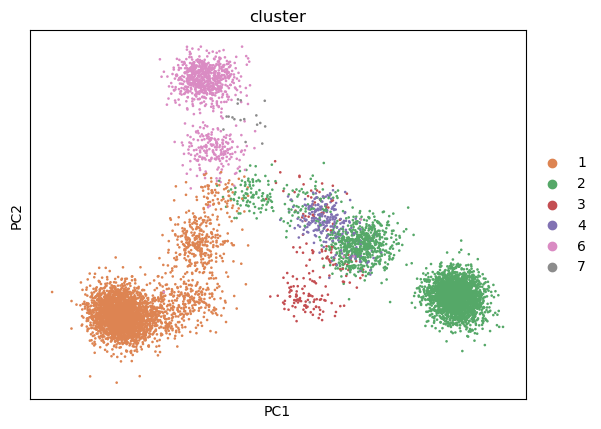

In [68]:
sc.pl.pca(adata, color=["cluster"])

And explicitly convert some annotations to categorical, hence we create new columns.
TODO(MUCDK): this seems unnecessary

In [69]:
# adata.obs["celltype"] = adata.obs["cluster"].astype("str").astype("category")
# adata.obs["time_categorical"] = adata.obs["time"].astype("category")

## Prepare the {class}`~moscot.problems.time.LineageProblem`

Apart from the `time_key` we need to set the `joint_attr` which defines where to look for the gene expression data. As we do not have a precomputed embedding, we set it to {obj}`None`, as this way *PCA* will performed on the {attr}`~anndata.AnnData.X` attribute.
If we did not have precomputed cost matrices we could also set the `lineage_attr` to `{'attr': 'obsm', 'key': 'barcodes', 'cost': 'barcode_distance'}`, which computes the cost matrices based on barcodes.
Since the {class}`~anndata.AnnData` object already contains the precomputed cost matrices, we simply extract them, as shown below.

In [70]:
lp = LineageProblem(adata=adata)
lp = lp.prepare(
    time_key="time",
    joint_attr=None,
    lineage_attr={"attr": "obsp", "key": "cost_matrices"},
)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


## Solve the {class}`~moscot.problems.time.LineageProblem`

The `alpha` parameter determines the influence of the lineage term as opposed to the gene expression. It must be in  $(0, 1]$. We choose `epsilon` to be small to get a crisper transport map. 

In [71]:
lp = lp.solve(alpha=0.99, epsilon=1e-3)

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(256, 8192)].                                   


## Analyzing cell type transitions

Now, we can compute the descendants of cells at time point `8`, aggregated by cell type.

In [73]:
cell_transition = lp.cell_transition(
    source=8,
    target=12,
    source_groups="cluster",
    target_groups="cluster",
    forward=True,
)

mpl.cell_transition(lp, fontsize=15, figsize=(5, 5))

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [int]

Similarly, we can plot ancestors by setting `forward=False`.

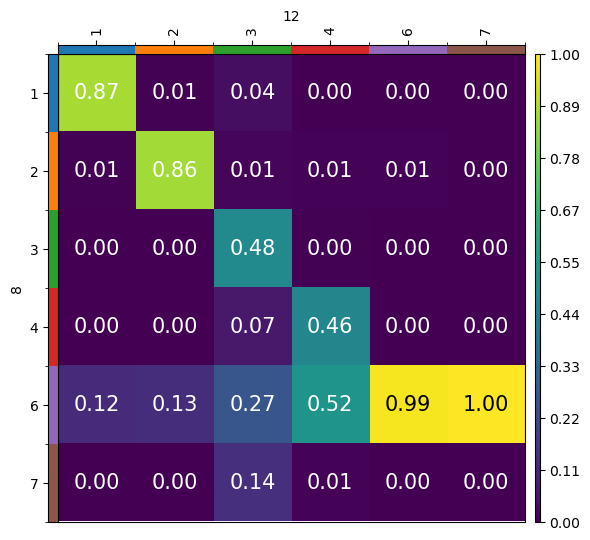

In [10]:
cell_transition = lp.cell_transition(
    source=8,
    target=12,
    source_groups="celltype",
    target_groups="celltype",
    forward=False,
)

mpl.cell_transition(lp, fontsize=15, figsize=(5, 5))

Another way to visualize cell type transitions is using a Sankey diagram. We order the annotations explicitly by providing a dictionary for `source_groups` and `target_groups`.

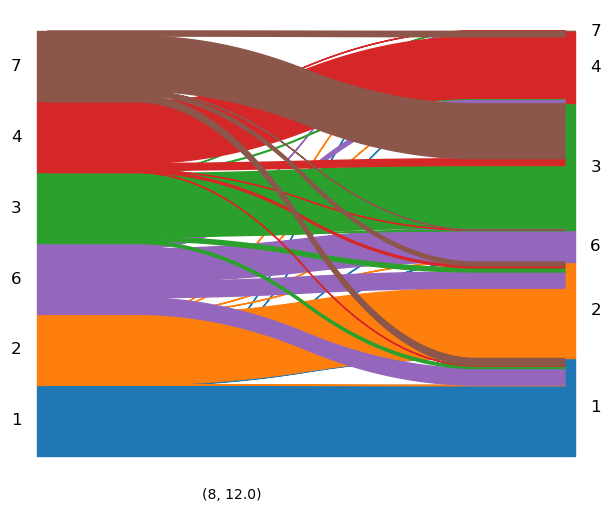

In [11]:
order = ["1", "2", "6", "3", "4", "7"]
lp.sankey(
    source=8,
    target=12,
    source_groups={"celltype": order},
    target_groups={"celltype": order},
)
mpl.sankey(lp, figsize=(6, 5))